In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import numpy as np
import pandas as pd
import os
import sys
import cv2
from tqdm.auto import tqdm 
import shutil
import scipy.stats

In [11]:
from utils_DP import get_bbox_area_normalize

In [4]:
base_dir = os.path.join('..', '..')
dataset = 'Dataset'
dataset_dir = os.path.join(base_dir, dataset)
Intermediates_dir = os.path.join('..', 'Intermediates')
Charts_Images_dir = os.path.join(Intermediates_dir, 'Charts_Images')
csv_txt_json_data = os.path.join(Intermediates_dir, 'csv_txt_json_data')

In [5]:
df_train = pd.read_csv(os.path.join(csv_txt_json_data, "dataset_after_processing.csv"), index_col= 0)

In [6]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,image_height,image_width,bbox_area,bbox_height,bbox_width,bbox_ratio_w/h,xmin_norm,ymin_norm,xmax_norm,ymax_norm
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\50a418190bc3fb1ef163...,860,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\21a10246a5ec7af15108...,1053,984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...,778,693,48792.0,152.0,321.0,2.112,0.331890,0.588689,0.795094,0.784062
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...,960,768,10672.0,92.0,116.0,1.261,0.548177,0.257292,0.699219,0.353125
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\063319de25ce7edb9b1c...,1024,846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_finding_train = df_train[df_train.class_id != 14]
df_non_finding_train = df_train[df_train.class_id == 14]

In [8]:
x = df_finding_train[["class_name", "class_id"]].groupby(by = ["class_name", "class_id"]).count().reset_index()
dct_class_ids = {}
for i in x.to_numpy():
  dct_class_ids[i[0]] = int(i[1])
dct_class_ids["No finding"] = 14

dct_class_ids

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13,
 'No finding': 14}

In [10]:
def GetKey(val):
   for key, value in dct_class_ids.items():
      if val == value:
        return key
      continue

### 1. Explore the ground truth bounding boxes area (after normalized)

In [12]:
df_finding_train["bbox_area_normalized"] = df_finding_train.apply(get_bbox_area_normalize, axis = 1)

In [13]:
df_finding_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,image_height,image_width,bbox_area,bbox_height,bbox_width,bbox_ratio_w/h,xmin_norm,ymin_norm,xmax_norm,ymax_norm,bbox_area_normalized
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...,778,693,48792.0,152.0,321.0,2.112,0.331890,0.588689,0.795094,0.784062,0.090497
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...,960,768,10672.0,92.0,116.0,1.261,0.548177,0.257292,0.699219,0.353125,0.014475
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,209.0,119.0,315.0,144.0,..\..\Dataset\train\train\1c32170b4af4ce1a3030...,1024,846,2650.0,25.0,106.0,4.240,0.247045,0.116211,0.372340,0.140625,0.003059
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,449.0,81.0,729.0,723.0,..\..\Dataset\train\train\0c7a38f293d5f5e4846a...,851,761,179760.0,642.0,280.0,0.436,0.590013,0.095182,0.957950,0.849589,0.277574
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,185.0,784.0,225.0,828.0,..\..\Dataset\train\train\47ed17dcb2cbeec15182...,1117,856,1760.0,44.0,40.0,0.909,0.216121,0.701880,0.262850,0.741271,0.001841


<function matplotlib.pyplot.show(close=None, block=None)>

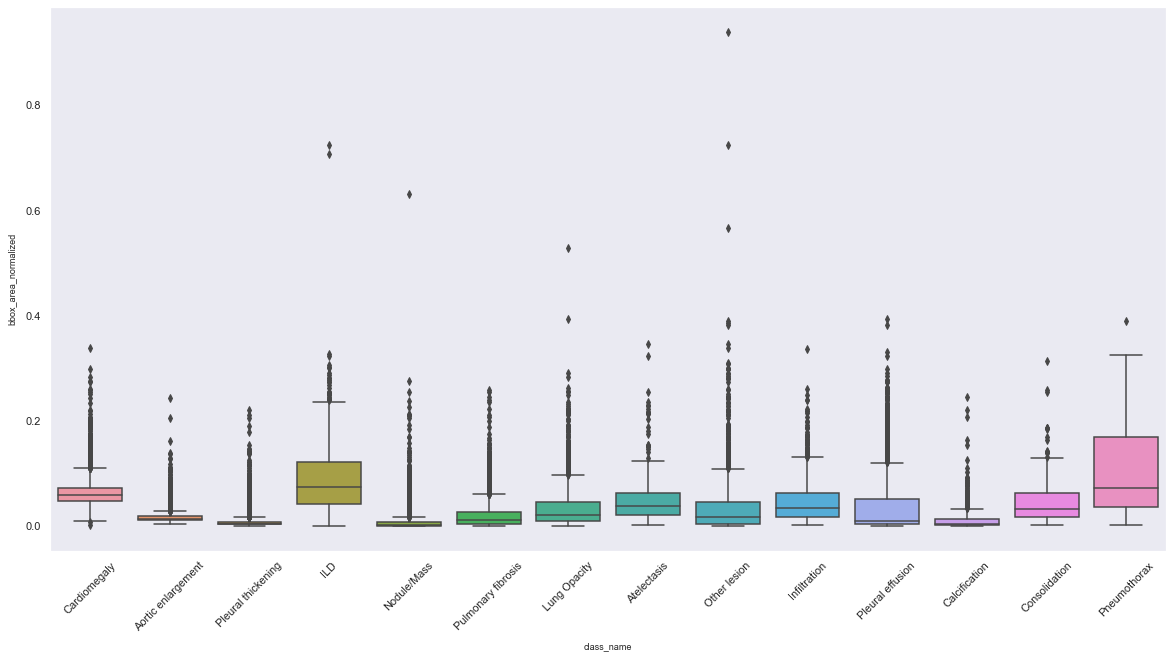

In [14]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_finding_train, x = "class_name", y = "bbox_area_normalized")
plt.xticks(rotation = 45)
plt.show

In [16]:
lst_outliner = []

for i in range(14):
  x = df_finding_train[df_finding_train.class_name == GetKey(i)][["bbox_area_normalized"]]
  iqr = scipy.stats.iqr(x)
  Q1 = x.quantile(0.25)
  lower_outlier = len(x[x["bbox_area_normalized"] < Q1.values[0] - iqr])
  Q3 = x.quantile(0.75)
  higher_outlier = len(x[x["bbox_area_normalized"] > Q3.values[0] + iqr])
  total_outlier = lower_outlier + higher_outlier
  lst_outliner.append(total_outlier)


In [17]:
df_outliner_bboxe_area_normalized_ori = pd.DataFrame({"class_name": [GetKey(i) for i in range(14)],
                                                      "class_id": [i for i in range(14)],
                                                      "number_outlier": lst_outliner})
df_outliner_bboxe_area_normalized_ori

,class_name,class_id,number_outlier
0,Aortic enlargement,0,635
1,Atelectasis,1,31
2,Calcification,2,136
3,Cardiomegaly,3,399
4,Consolidation,4,37
5,ILD,5,64
6,Infiltration,6,109
7,Lung Opacity,7,241
8,Nodule/Mass,8,437
9,Other lesion,9,239


+ This is the standard for us after feature engineering bounding boxes

In [18]:
df_outliner_bboxe_area_normalized_ori = df_outliner_bboxe_area_normalized_ori.sort_values("number_outlier", ascending= False)
df_outliner_bboxe_area_normalized_ori

,class_name,class_id,number_outlier
0,Aortic enlargement,0,635
11,Pleural thickening,11,635
13,Pulmonary fibrosis,13,503
8,Nodule/Mass,8,437
3,Cardiomegaly,3,399
10,Pleural effusion,10,344
7,Lung Opacity,7,241
9,Other lesion,9,239
2,Calcification,2,136
6,Infiltration,6,109


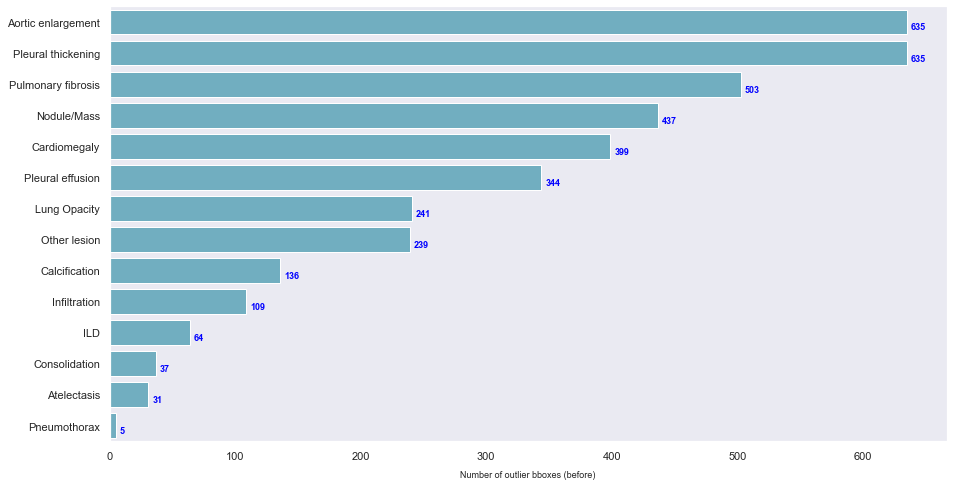

In [19]:
plt.figure(figsize= (15, 8))
sns.barplot(data = df_outliner_bboxe_area_normalized_ori, y =  "class_name", x = "number_outlier", color = "c")
for i, v in enumerate(df_outliner_bboxe_area_normalized_ori["number_outlier"].values):
  plt.text(v + 3, i + .25, str(int(v)), color='blue', fontweight='bold')
plt.xlabel("Number of outlier bboxes (before)")
plt.ylabel(None)
#plt.savefig(os.path.join(chart_path, "9.Number_of_outlier_bboxes_(before).png"))

plt.show()

In [20]:
mean_bbox_area_normalized = dict()
for i in range(14):
  series = df_finding_train[df_finding_train.class_id == i].bbox_area_normalized.describe()
  print(f"class id = {i} with the mean of bbox area = {series[5]}")
  mean_bbox_area_normalized[i] = series[5]
  print()

class id = 0 with the mean of bbox area = 0.013700562867710719

class id = 1 with the mean of bbox area = 0.037258572048611126

class id = 2 with the mean of bbox area = 0.003823362403429587

class id = 3 with the mean of bbox area = 0.05829962387339439

class id = 4 with the mean of bbox area = 0.03240899402223421

class id = 5 with the mean of bbox area = 0.07369473847763164

class id = 6 with the mean of bbox area = 0.03367986295803783

class id = 7 with the mean of bbox area = 0.021129608154296875

class id = 8 with the mean of bbox area = 0.001375885515827437

class id = 9 with the mean of bbox area = 0.01678984947259265

class id = 10 with the mean of bbox area = 0.008780509323221018

class id = 11 with the mean of bbox area = 0.0043965657552083315

class id = 12 with the mean of bbox area = 0.07253665517679508

class id = 13 with the mean of bbox area = 0.010583627061044444



In [21]:
df = pd.DataFrame({"class_id": mean_bbox_area_normalized.keys(), 
                   "class_name": [GetKey(i) for i in mean_bbox_area_normalized.keys()],
                   "mean_bb_area_normalized": mean_bbox_area_normalized.values()})
df = df.sort_values(by = "mean_bb_area_normalized", ascending= False)

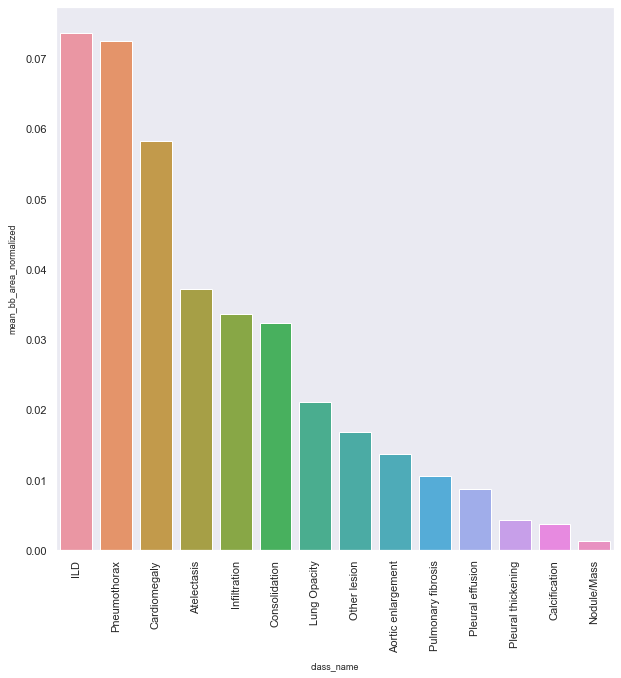

In [22]:
plt.figure(figsize = (10,10))
sns.barplot(data = df, x = df["class_name"], y = df["mean_bb_area_normalized"])
plt.xticks(rotation = 90)
plt.show()

+ The various bounding boxes area
+ the size of Other lession has too many outlines which is biggest size but the overall is just the middle size --> let explore this by Heat Map

In [26]:
heatmap_size = (500,400)
bbox_heatmap = df_finding_train[[ "class_id","xmin_norm", "ymin_norm", "xmax_norm", "ymax_norm"]]
bbox_heatmap["xmin_norm"] = bbox_heatmap["xmin_norm"] * heatmap_size[1]
bbox_heatmap["xmax_norm"] = bbox_heatmap["xmax_norm"] * heatmap_size[1]
bbox_heatmap["ymin_norm"] = bbox_heatmap["ymin_norm"] * heatmap_size[0]
bbox_heatmap["ymax_norm"] = bbox_heatmap["ymax_norm"] * heatmap_size[0]
bbox_heatmap = bbox_heatmap.astype(int)

In [27]:
def draw_bbox_on_heatmap(bboxes, class_id, heatmap_size):
    # initialize empty (full black) heatmap
    heatmap = np.zeros((heatmap_size))
    for _, row in bboxes[bboxes["class_id"] == class_id].iterrows():
        # draw white bboxes on black heatmap based on bboxes coordinate
        # that mean multiple bboxes which same class_id will be drawn on same heatmap
        heatmap[row[2]:row[4], row[1]:row[3]] += 1
    return heatmap

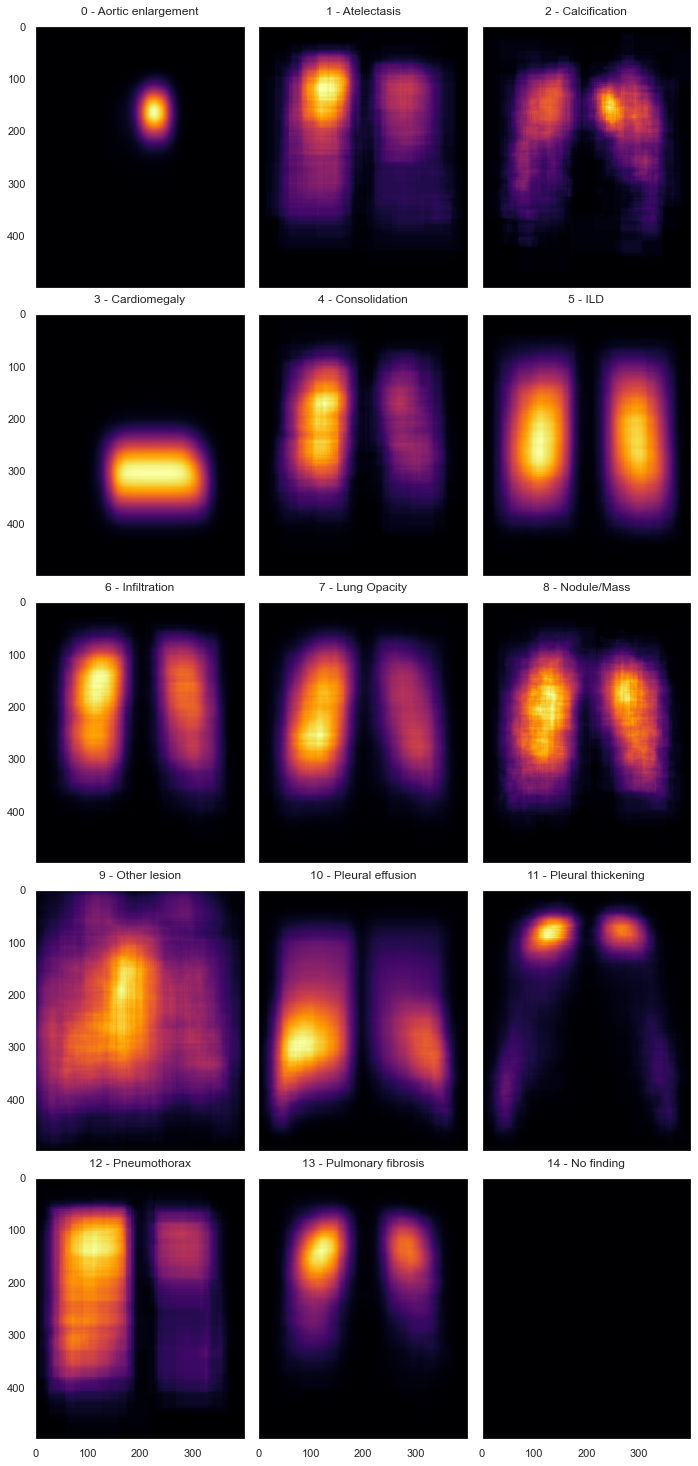

In [28]:
fig, axes = plt.subplots(nrows=5, ncols=3, sharey=True, sharex=True, 
                         gridspec_kw={'hspace': .1, 'wspace': 0}, figsize=(12, 26))

for i, ax in enumerate(axes.flatten()):
    # display heatmap
    ax.imshow(draw_bbox_on_heatmap(bbox_heatmap, i, heatmap_size),
              cmap="inferno", interpolation='nearest')
    # set title for heatmap
    _ = ax.set_title(str(i) + ' - ' + GetKey(i), size=12)

#plt.savefig(os.path.join(chart_path, "13.Heat_map.png"))
plt.show()

### 2. Disease Cluster (base on bounding boxes area [after normalized]) - K mean

In [29]:
df_finding_train_sub_1  = df_finding_train[["class_name", "bbox_area_normalized"]]

In [30]:
df_finding_train_sub_1 = df_finding_train_sub_1.groupby(by = "class_name").mean().sort_values(by = "bbox_area_normalized", ascending = False)
df_finding_train_sub_1 = df_finding_train_sub_1.reset_index()

In [31]:
df_finding_train_sub_1 = pd.get_dummies(df_finding_train_sub_1)

In [32]:
df_finding_train_sub_1

,bbox_area_normalized,class_name_Aortic enlargement,class_name_Atelectasis,class_name_Calcification,class_name_Cardiomegaly,class_name_Consolidation,class_name_ILD,class_name_Infiltration,class_name_Lung Opacity,class_name_Nodule/Mass,class_name_Other lesion,class_name_Pleural effusion,class_name_Pleural thickening,class_name_Pneumothorax,class_name_Pulmonary fibrosis
0,0.104126,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.089126,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.062670,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.053405,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.045972,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0.044383,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0.039533,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0.036077,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0.034268,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0.020256,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
df_finding_train_sub_1["bbox_area_normalized"] = df_finding_train_sub_1["bbox_area_normalized"] * 1000

In [34]:
from scipy.spatial.distance import cdist 
from sklearn import metrics 
from sklearn.cluster import KMeans

distortions = [] 
k = range(1,7)
for K in k:
  kmeanmodel = KMeans(n_clusters=K) 
  kmeanmodel.fit(df_finding_train_sub_1)
  distortions.append(sum(np.min(cdist(df_finding_train_sub_1,
                                      kmeanmodel.cluster_centers_,"euclidean"), axis = 1))/df_finding_train_sub_1.shape[0])

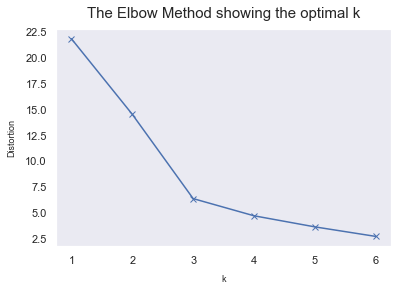

In [35]:
plt.plot(k, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
#plt.savefig("Elbow_Method.png")
plt.show()

+ choose K = 3

In [36]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_finding_train_sub_1)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [37]:
df_finding_train_sub_1["label"] = labels
df_finding_train_sub_1["class"] = df_finding_train[["class_name", "bbox_area_normalized"]].groupby(by = "class_name").mean().sort_values(by = "bbox_area_normalized", ascending = False).index

In [38]:
df_finding_train_sub_1["bbox_area_normalized"] = df_finding_train_sub_1["bbox_area_normalized"] / 1000

In [39]:
df_finding_train_sub_1["class_name"] = df_finding_train[["class_name", "bbox_area_normalized"]].groupby(by = "class_name").mean().sort_values(by = "bbox_area_normalized", ascending = False).index

In [40]:
df_finding_train_sub_1 = df_finding_train_sub_1[["bbox_area_normalized", "class_name", "label"]]

In [41]:
df_finding_train_sub_1

,bbox_area_normalized,class_name,label
0,0.104126,Pneumothorax,1
1,0.089126,ILD,1
2,0.062670,Cardiomegaly,0
3,0.053405,Atelectasis,0
4,0.045972,Infiltration,0
5,0.044383,Consolidation,0
6,0.039533,Pleural effusion,0
7,0.036077,Other lesion,0
8,0.034268,Lung Opacity,0
9,0.020256,Pulmonary fibrosis,2


+ But when using K_mean --> the values will be create randomly --> reset it like this format

In [42]:
df_finding_train_sub_1["label"] = [2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0 ,0, 0]

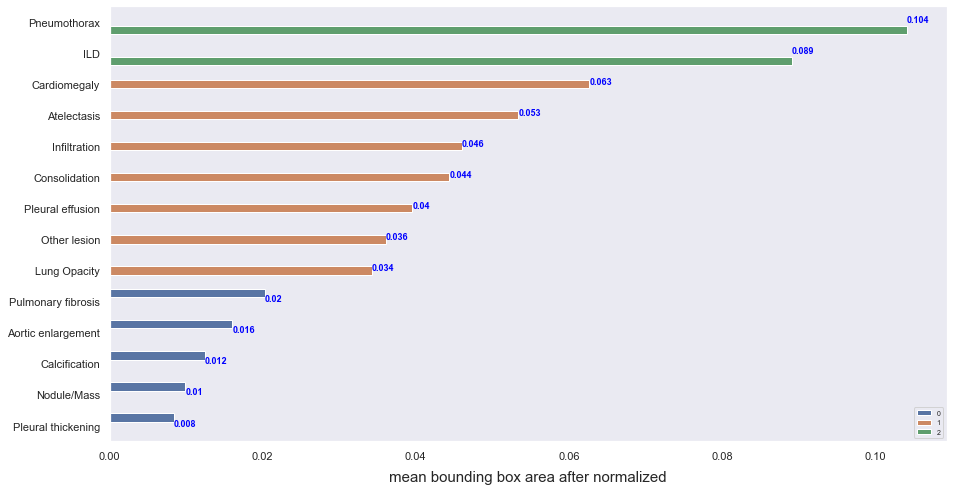

In [43]:
plt.figure(figsize= (15, 8))
sns.barplot(data = df_finding_train_sub_1, y =  "class_name", x = "bbox_area_normalized", hue = "label")
for i, v in enumerate(df_finding_train_sub_1["bbox_area_normalized"].values):
  plt.text(v , i, str(round(v, 3)), color='blue', fontweight='bold')
plt.xlabel("mean bounding box area after normalized", fontsize = 15)
plt.ylabel(None)
plt.legend(loc = "lower right")
#plt.savefig("mean bounding box area after normalize_after_K_mean.png")

plt.show()


### 3. Save file

In [45]:
df_finding_train_sub_1.to_csv(os.path.join(csv_txt_json_data, "K_mean_cluster_diseases.csv"))
df_finding_train_sub_1

,bbox_area_normalized,class_name,label
0,0.104126,Pneumothorax,2
1,0.089126,ILD,2
2,0.062670,Cardiomegaly,1
3,0.053405,Atelectasis,1
4,0.045972,Infiltration,1
5,0.044383,Consolidation,1
6,0.039533,Pleural effusion,1
7,0.036077,Other lesion,1
8,0.034268,Lung Opacity,1
9,0.020256,Pulmonary fibrosis,0


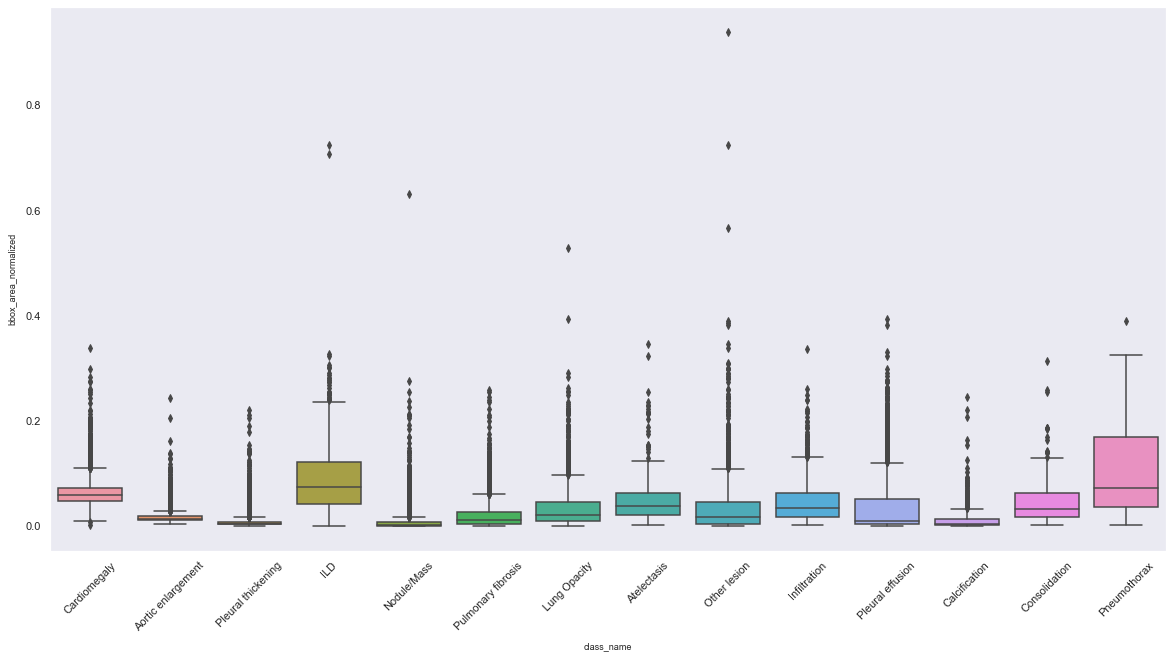

In [47]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_finding_train, x = "class_name", y = "bbox_area_normalized")
plt.xticks(rotation = 45)
plt.savefig(os.path.join(Charts_Images_dir, "bbox_area_normalized.png"))
plt.show()

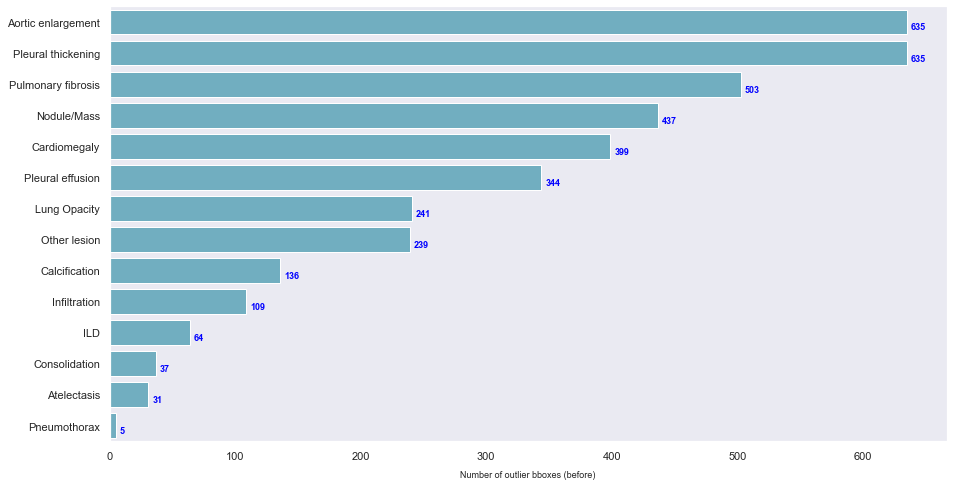

In [48]:
plt.figure(figsize= (15, 8))
sns.barplot(data = df_outliner_bboxe_area_normalized_ori, y =  "class_name", x = "number_outlier", color = "c")
for i, v in enumerate(df_outliner_bboxe_area_normalized_ori["number_outlier"].values):
  plt.text(v + 3, i + .25, str(int(v)), color='blue', fontweight='bold')
plt.xlabel("Number of outlier bboxes (before)")
plt.ylabel(None)
plt.savefig(os.path.join(Charts_Images_dir, "Number of outlier bboxes(before).png"))

plt.show()

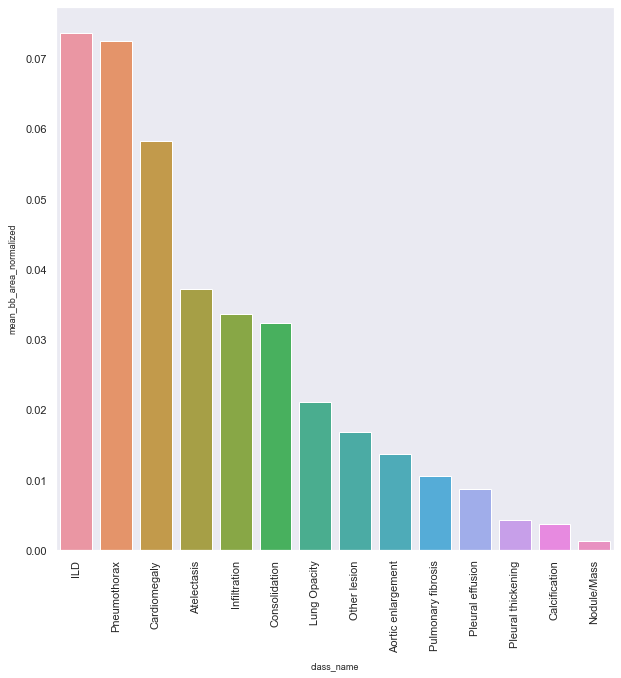

In [49]:
plt.figure(figsize = (10,10))
sns.barplot(data = df, x = df["class_name"], y = df["mean_bb_area_normalized"])
plt.xticks(rotation = 90)
plt.savefig(os.path.join(Charts_Images_dir, "mean_bb_area_normalized.png"))
plt.show()

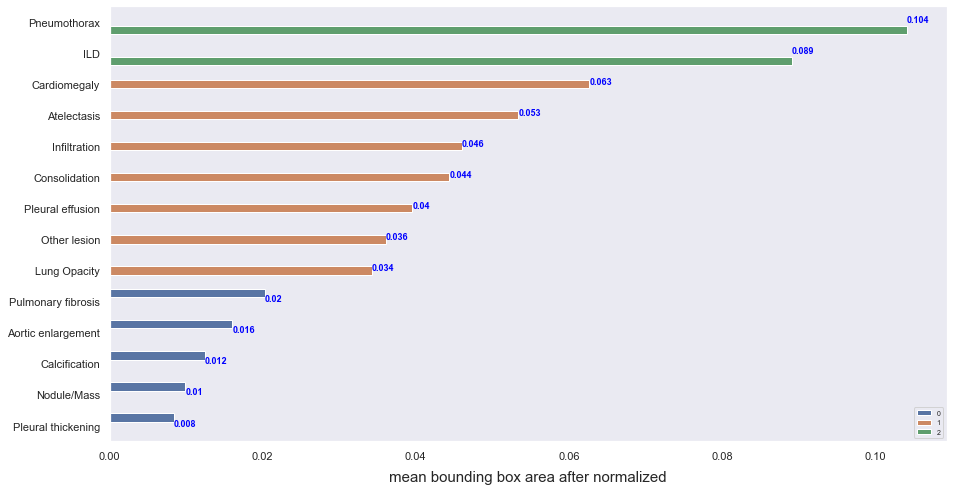

In [46]:
plt.figure(figsize= (15, 8))
sns.barplot(data = df_finding_train_sub_1, y =  "class_name", x = "bbox_area_normalized", hue = "label")
for i, v in enumerate(df_finding_train_sub_1["bbox_area_normalized"].values):
  plt.text(v , i, str(round(v, 3)), color='blue', fontweight='bold')
plt.xlabel("mean bounding box area after normalized", fontsize = 15)
plt.ylabel(None)
plt.legend(loc = "lower right")
plt.savefig(os.path.join(Charts_Images_dir, "K_mean_cluster_diseases.png"))

plt.show()
